<a href="https://colab.research.google.com/github/MateusMaruzka/lowcostsensors_calib/blob/main/calib_lowcostsensors_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Instalando as dependências:


1.   Tensorflow Decision Forests



In [ ]:
#!gcloud auth login
#gsutil -m cp -r "gs://cloud-ai-platform-6a74c02d-879c-498f-af7b-eb05350aaed7/model-6997608658515263488" .

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install tensorflow_decision_forests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, \
                                    validation_curve, cross_val_score, \
                                    cross_validate, \
                                    RepeatedKFold
from sys import version
print("running: ", version)

# Downloading the dataset
!wget https://raw.githubusercontent.com/MateusMaruzka/lowcostsensors_calib/main/dataset.csv
!wget https://raw.githubusercontent.com/MateusMaruzka/lowcostsensors_calib/main/min_ds_gm5000_envcity.csv

running:  3.8.15 (default, Oct 12 2022, 19:14:39) 
[GCC 7.5.0]
--2022-12-05 22:33:38--  https://raw.githubusercontent.com/MateusMaruzka/lowcostsensors_calib/main/dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1024137 (1000K) [text/plain]
Saving to: ‘dataset.csv.3’

dataset.csv.3       100%[===================>]   1000K  --.-KB/s    in 0.06s   

2022-12-05 22:33:38 (16.3 MB/s) - ‘dataset.csv.3’ saved [1024137/1024137]

--2022-12-05 22:33:39--  https://raw.githubusercontent.com/MateusMaruzka/lowcostsensors_calib/main/min_ds_gm5000_envcity.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:4

In [ ]:
df = pd.read_csv('min_ds_gm5000_envcity.csv')
df.set_index('Unnamed: 0', inplace = True)
df.dropna(inplace=True)
idx = df['temperatura_envcity'] > 100
df['temperatura_envcity'][idx] = 100
idx = df['umidade_envcity'] > 100
df['umidade_envcity'][idx] = 100

### Tukey's rule for outliers (IQR rule)

1. IQR =  Q3 - Q1
2. upper limit = Q3 + 1.5*IQR
3. lower limit = Q1 - 1.5*IQR

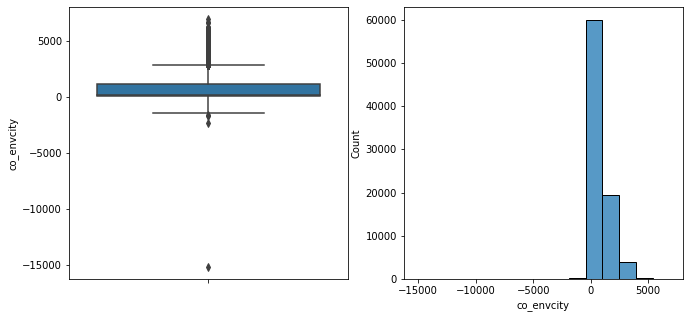

count    83682.000000
mean       632.098552
std        866.107163
min     -15160.296000
25%         65.812000
50%        178.875000
75%       1175.235500
max       6901.551000
Name: co_envcity, dtype: float64

In [ ]:
l = 'co_envcity'
ref_l = 'co_iat'

def quantiles(df):
  Q1 = df.quantile(0.25)
  Q3 = df.quantile(0.75)
  IQR = Q3 - Q1
  lower_lim = Q1 - 0.5*IQR
  upper_lim = Q3 + 0.5*IQR
  return Q1, Q3, lower_lim, upper_lim, IQR

def boxplot_histplot(data):
  fig, ax = plt.subplots(1, 2, figsize = (11,5))
  sns.boxplot(y = data, ax = ax[0])
  sns.histplot(data, ax = ax[1], bins = 15)
  plt.show()

boxplot_histplot(df[l])
df[l].describe()

In [ ]:
Q1, Q3, lower_lim, upper_lim, IQR = quantiles(df[l])
print(f'First quantile = {Q1}')
print(f'Third quantile = {Q3}')
print(f'IQR = {IQR}')
print(f'Lower limit = {lower_lim}')
print(f'upper limit = {upper_lim}')

First quantile = 65.812
Third quantile = 1175.2355
IQR = 1109.4235
Lower limit = -488.89975000000004
upper limit = 1729.9472500000002


In [ ]:
outliers = (df[l] < lower_lim) | (df[l] > upper_lim)
print(len(df[l][outliers]))
print(f'Outliers -> {len(df[l][outliers])*100 / len(df[l])} %')

11535
Outliers -> 13.784326378432638 %


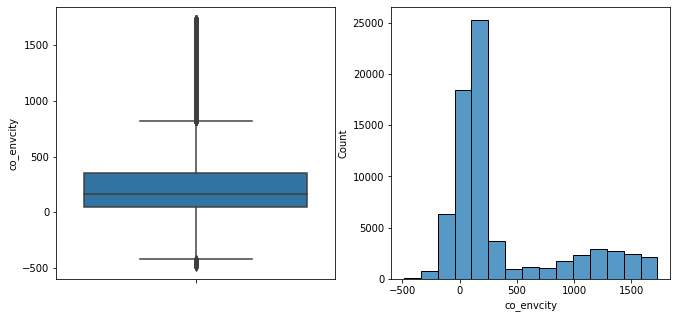

In [ ]:
#  Dropping outliers
# Y = df[l][~outliers] # Referência
# X = df[ref_l][~outliers]

boxplot_histplot(df[l][~outliers])

# Modifying outliers by winsorize method
# from scipy.stats.mstats import winsorize

# df_winsorize = winsorize(df[l], (0.01, 0.02))
# boxplot_histplot(df_winsorize)

# # Log transformation: reduces the skewness of data and tries to make it normal

# df_log = np.log(df[l])
# boxplot_histplot(df_log)

11535
Outliers:  co
11535
Outliers -> 13.784326378432638 %


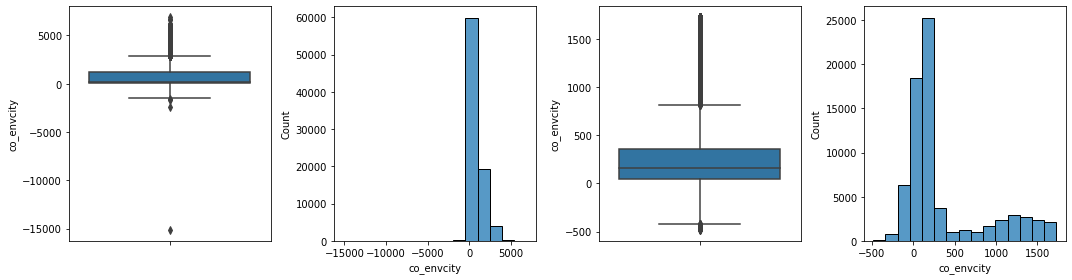

11287
Outliers:  h2s
11287
Outliers -> 13.487966348796634 %


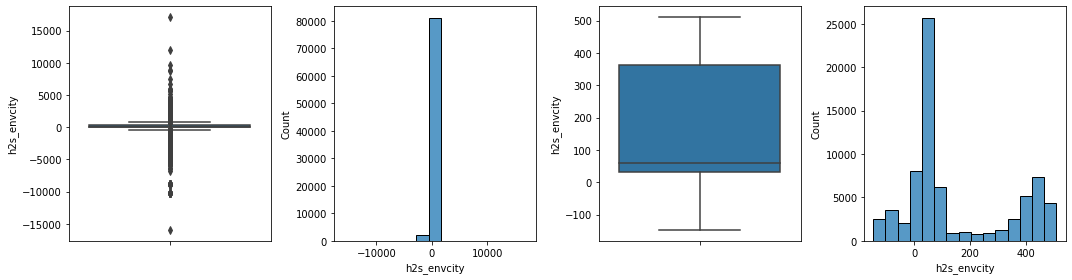

4101
Outliers:  no2
4101
Outliers -> 4.900695490069549 %


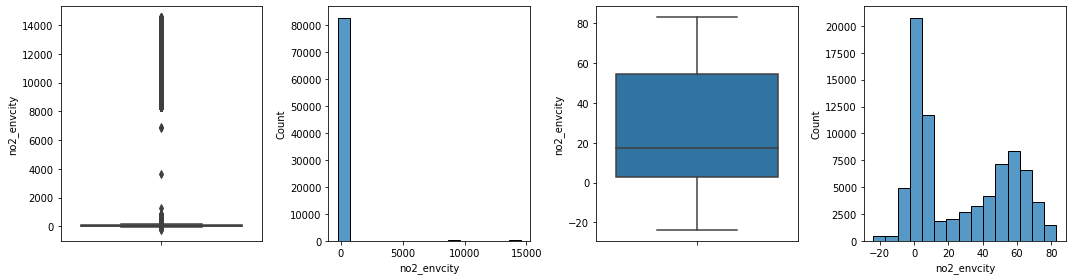

18217
Outliers:  so2
18217
Outliers -> 21.769317176931718 %


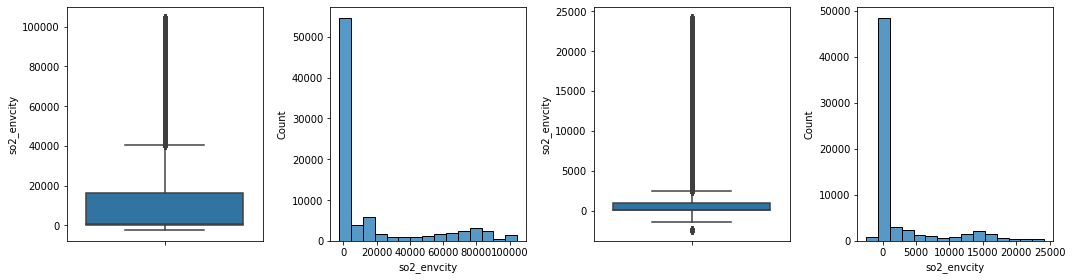

506
Outliers:  nh3
506
Outliers -> 0.604670060467006 %


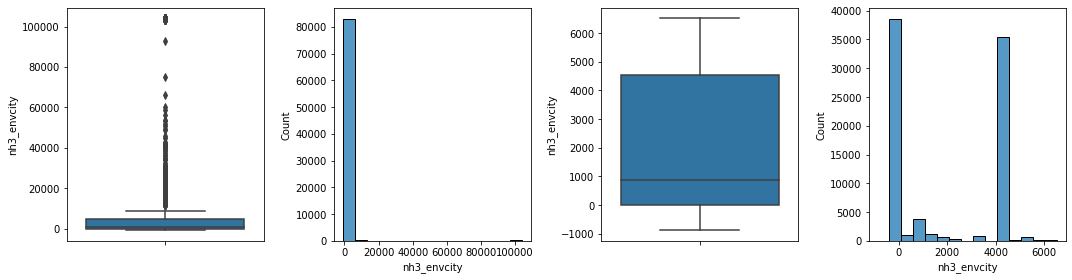

25355
Outliers:  o3
25355
Outliers -> 30.2992280299228 %


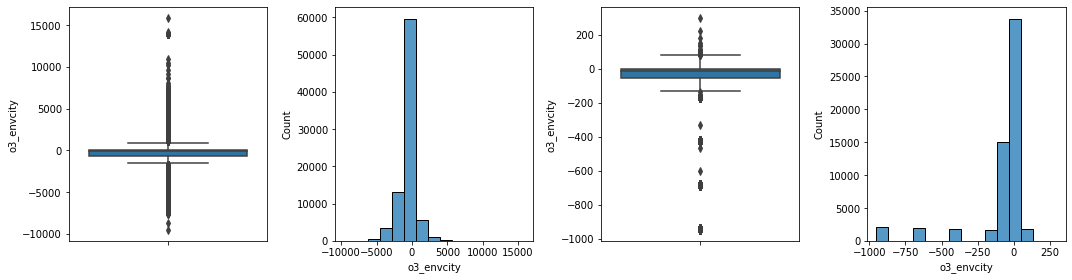

{'co': 13.784326378432638, 'h2s': 13.487966348796634, 'no2': 4.900695490069549, 'so2': 21.769317176931718, 'nh3': 0.604670060467006, 'o3': 30.2992280299228}


In [ ]:
def outliers_df(df, method = 'drop'): 
  """
  Gera um boxplot pra cada variável no df em relação a referência
  method: 'drop', 'winsorize' e 'log'
  """
  label = ['co', 'h2s', 'no2', 'so2', 'nh3', 'o3']
  res = {}
  for l in label:

    data = df[l + '_envcity']
    
    Q1, Q3, low, up, IQR = quantiles(data)
    outliers = (data < low) | (data > up)
    print(np.sum(outliers))
    print('Outliers: ', l)
    print(len(data[outliers]))
    outliers_num = len(data[outliers])*100 / len(data)
    print(f'Outliers -> {outliers_num} %')

    res[l] =  outliers_num

    fig, ax = plt.subplots(1, 4, figsize = (15,4))

    sns.boxplot(y = data, ax = ax[0], whis=1.5)
    # ax[0].boxplot(data)
    sns.histplot(data, ax = ax[1], bins = 15)

    if method == 'drop':
      sns.boxplot(y = data[~outliers], ax = ax[2],  whis=1.5)
      sns.histplot(data[~outliers], ax = ax[3], bins = 15)
    elif method == 'winsorize':
      sns.boxplot(y = winsorize(data, (0.01, 0.02)), ax = ax[2])
      sns.histplot(winsorize(data, (0.01, 0.02)), ax = ax[3], bins = 15)
    elif method == 'log':
      sns.boxplot(y = np.log(data), ax = ax[2])
      sns.histplot(np.log(data), ax = ax[3], bins = 15)

    plt.tight_layout()
    plt.show()

  return res

print(outliers_df(df, 'drop'))
# df.describe()

In [ ]:
# Split the dataset into a training and a testing dataset.

def split_dataset(dataset, test_ratio=0.30):
  """Splits a panda dataframe in two."""
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]


In [ ]:
from scipy.stats.mstats_basic import winsorize
label = 'co_thermo'
label_envcity = 'co_envcity'

# Outliers
# Q1, Q3, lower_lim, upper_lim, IQR = quantiles(df[l])
# outliers = (df[label_envcity] < lower_lim) | (df[label_envcity] > upper_lim)
Yco = df[label]

Xco = df.loc[Yco.index][[label,'temperatura_envcity','umidade_envcity', label_envcity]]
Xco[label_envcity] = winsorize(Xco[label_envcity])

train_ds_pd, test_ds_pd = split_dataset(Xco)
print("{} examples in training, {} examples for testing.".format(len(train_ds_pd), len(test_ds_pd)))

train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)


58471 examples in training, 25211 examples for testing.


In [ ]:
# Train a Random Forest model.
model = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION, verbose=0)
# model.fit(x=X_train, y=y_train)
model.fit(train_ds)

In [ ]:
# Summary of the model structure.
model.summary()

Model: "random_forest_model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (3):
	co_envcity
	temperatura_envcity
	umidade_envcity

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.             "__LABEL" 13.485551 ################
    2.     "umidade_envcity"  1.898539 #
    3.          "co_envcity"  1.449937 
    4. "temperatura_envcity"  0.653477 

Variable Importance: NUM_AS_ROOT:
    1. "temperatura_envcity" 199.000000 ################
    2.          "co_envcity" 101.000000 

Variable Importance: NUM_NODES:
    1.          "co_envcity" 521681.000000 ################
    2. "temperatura_envcity" 341543.000000 ####
    3.     "umidade_envcity" 274687.000000 

Variable Importance: SUM_SCORE:
    1.

In [ ]:
# Evaluate the model.
import math

model.compile(metrics=["mse", "mape"])
evaluation = model.evaluate(train_ds, return_dict=True)
print(evaluation)
print(f"MSE: {evaluation['mse']}")
print(f"RMSE: {math.sqrt(evaluation['mse'])}")

# Export the model to a SavedModel.
# model.save("project/model")

59/59 [==============================] - 4s 62ms/step - loss: 0.0000e+00 - mse: 13908.8262 - mape: 25.3997
{'loss': 0.0, 'mse': 13908.826171875, 'mape': 25.399681091308594}
MSE: 13908.826171875
RMSE: 117.93568659178187


In [ ]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)

In [ ]:
model.make_inspector().features()


In [ ]:
model.make_inspector().variable_importances()


In [ ]:
model.make_inspector().evaluation()


Evaluation(num_examples=58471, accuracy=None, loss=None, rmse=149.71597023579022, ndcg=None, aucs=None, auuc=None, qini=None)

[TrainLog(num_trees=1, evaluation=Evaluation(num_examples=21542, accuracy=None, loss=None, rmse=181.31302739932525, ndcg=None, aucs=None, auuc=None, qini=None)), TrainLog(num_trees=11, evaluation=Evaluation(num_examples=58086, accuracy=None, loss=None, rmse=157.73312728695717, ndcg=None, aucs=None, auuc=None, qini=None)), TrainLog(num_trees=21, evaluation=Evaluation(num_examples=58467, accuracy=None, loss=None, rmse=153.11609875759413, ndcg=None, aucs=None, auuc=None, qini=None)), TrainLog(num_trees=31, evaluation=Evaluation(num_examples=58471, accuracy=None, loss=None, rmse=152.26741757544187, ndcg=None, aucs=None, auuc=None, qini=None)), TrainLog(num_trees=41, evaluation=Evaluation(num_examples=58471, accuracy=None, loss=None, rmse=150.93570950424845, ndcg=None, aucs=None, auuc=None, qini=None)), TrainLog(num_trees=51, evaluation=Evaluation(num_examples=58471, accuracy=None, loss=None, rmse=150.37203900576978, ndcg=None, aucs=None, auuc=None, qini=None)), TrainLog(num_trees=61, evalu

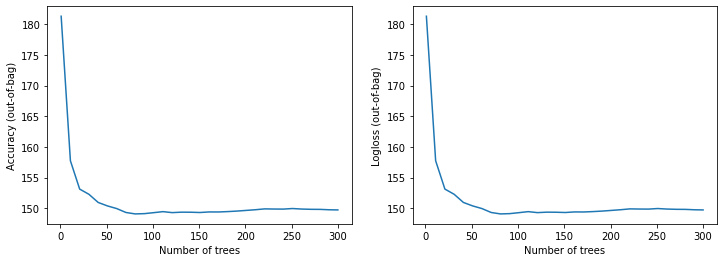

In [ ]:
logs = model.make_inspector().training_logs()
print(logs)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()

In [ ]:
model.predict(test_ds)

26/26 [==============================] - 1s 45ms/step


array([[600.6193 ],
       [544.51337],
       [596.8809 ],
       ...,
       [215.29674],
       [212.69946],
       [213.90068]], dtype=float32)

In [ ]:
test_ds_pd[label]

Unnamed: 0
2022-05-02 16:02:00+00:00    600.0
2022-05-02 16:09:00+00:00    600.0
2022-05-02 16:11:00+00:00    600.0
2022-05-02 16:12:00+00:00    620.0
2022-05-02 16:13:00+00:00    620.0
                             ...  
2022-11-05 14:27:00+00:00    220.0
2022-11-05 14:30:00+00:00    220.0
2022-11-05 14:34:00+00:00    230.0
2022-11-05 14:36:00+00:00    220.0
2022-11-05 14:37:00+00:00    230.0
Name: co_thermo, Length: 25211, dtype: float64

26/26 [==============================] - 1s 51ms/step


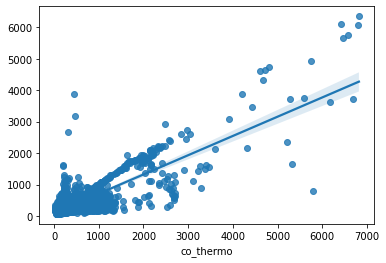

In [ ]:
sns.regplot(x = test_ds_pd[label], y = model.predict(test_ds))

In [ ]:
sns.regplot(x = test_ds_pd[label], y = test_ds_pd[label_envcity])

NameError: ignored